In [9]:
from fenics import *
from dolfin import *
#from mshr import *
import matplotlib.pyplot as plt

comm = MPI.comm_world
rank = MPI.rank(comm)
import numpy as np

In [267]:
data = HDF5File(comm, f"data_test_count_49_w_0.2236_time_2000.h5", 'r')

mesh = Mesh()
data.read(mesh, "mesh", False)

# plot(mesh)

In [3]:
nx = 60
ny = 60
LX = 128 
LY = 128

# Sub domain for Periodic boundary condition
class PeriodicBoundary(SubDomain):

    def inside(self, x, on_boundary):
        return bool((near(x[0], 0) or near(x[1], 0)) and
                (not ((near(x[0], 0) and near(x[1], LY)) or
                        (near(x[0], LX) and near(x[1], 0)))) and on_boundary)

    def map(self, x, y):
        if near(x[0], LX) and near(x[1], LY):
            y[0] = x[0] - LX
            y[1] = x[1] - LY
        elif near(x[0], LX):
            y[0] = x[0] - LX
            y[1] = x[1]
        else:   # near(x[1], 127)
            y[0] = x[0]
            y[1] = x[1] - LY

In [4]:
V = VectorElement("Lagrange", mesh.ufl_cell(), 1, dim = 2)
Q = FiniteElement("Lagrange", mesh.ufl_cell(), 1)
MFS = FunctionSpace(mesh, MixedElement([Q, V]), constrained_domain = PeriodicBoundary())

VFS = FunctionSpace(mesh, V, constrained_domain = PeriodicBoundary())
FS  = FunctionSpace(mesh, Q, constrained_domain = PeriodicBoundary())

u_new = Function(MFS) 
w = Function(FS)

(rho_new, tau_new) = split(u_new)

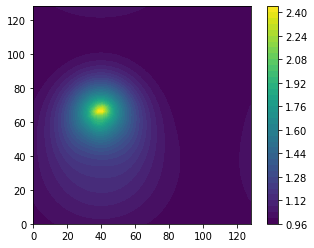

In [237]:
t = 200
data.read(u_new, f"u_new/Vector/vector_{t}")

c = plot(rho_new)
plt.colorbar(c)

In [238]:
taux = project(tau_new[0]/rho_new, FS)
tauy = project(tau_new[1]/rho_new, FS)

In [239]:
theta = Function(FS)

for i in range(len(theta.vector()[:])):
    theta.vector()[i] = np.arctan2(tauy.vector()[i], taux.vector()[i])

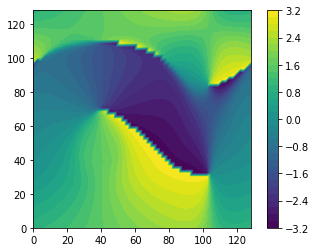

In [240]:
c = plot(theta)
plt.colorbar(c)

In [241]:
def fenics_to_numpyarray(rho):
    
    x = np.linspace(0, LX, LX)
    y = np.linspace(0, LY, LX)
    xx, yy = np.meshgrid(x, y, sparse = False, indexing = 'ij')
    
    rho_ = project(rho, FS)
    rho_vec = np.vectorize(rho_)
    rho_ar = rho_vec(xx, yy)
    
    return rho_ar


theta_ar = fenics_to_numpyarray(theta)

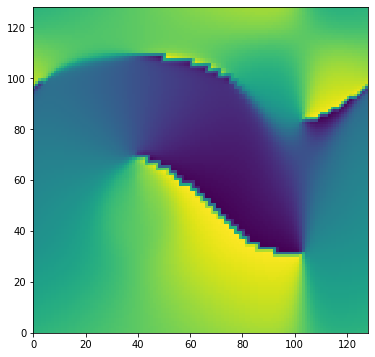

In [242]:
plt.figure(figsize = (6, 6))
plt.pcolor(theta_ar.T)

In [243]:
rho_ar = fenics_to_numpyarray(rho_new)

In [244]:
import math
max_value = np.max(rho_ar)
max_index = np.unravel_index(np.argmax(rho_ar), rho_ar.shape)

x0 = max_index[0]
y0 = max_index[1]

phi = np.zeros([LX, LY])

for x in range(LX):
    for y in range(LY):
        if x != x0:  # To avoid division by zero
            phi[x, y] = math.atan2((y - y0), (x - x0))
        elif y > y0:
            phi[x, y] = math.pi / 2
        elif y < y0:
            phi[x, y] = -math.pi / 2
        else:
            phi[x, y] = 0.0

<ipython-input-245-ba6a0df3c90f>:3: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(c)


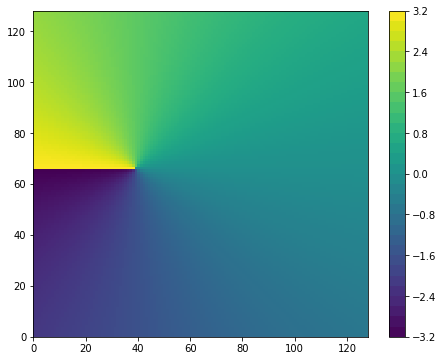

In [245]:
plt.figure(figsize = (7.5, 6))
plt.pcolor(phi.T)
plt.colorbar(c)

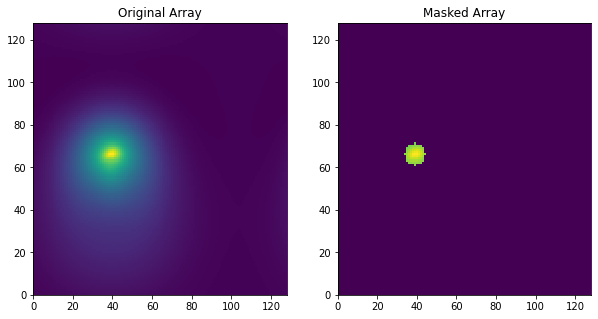

In [261]:

def create_circular_mask(rows, cols, center, radius):
    y, x = np.ogrid[:rows, :cols]
    distance = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    mask = distance <= radius
    return mask

# Parameters
array_size = LX
center_x = x0
center_y = y0
radius = 5

# Create a circular mask
mask = create_circular_mask(array_size, array_size, (center_x, center_y), radius)

# Create a sample array
input_array = rho_ar.T

# Apply the mask
masked_array = np.where(mask, input_array, 0)

# Plot the original array and the masked array
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.pcolor(input_array, cmap='viridis')
plt.title('Original Array')

plt.subplot(1, 2, 2)
plt.pcolor(masked_array, cmap='viridis')
plt.title('Masked Array')

plt.show()


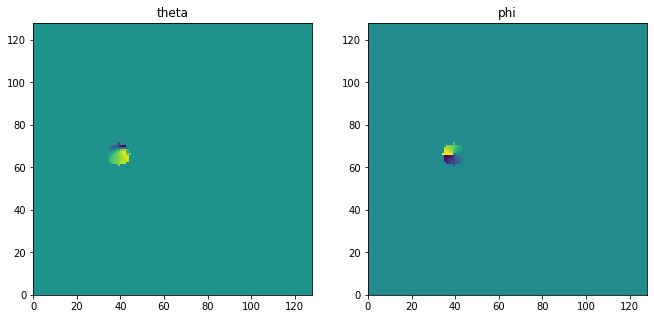

In [262]:
theta_new  = np.where(mask, theta_ar.T, 0) # polarization vector 

phi_new = np.where(mask, phi.T, 0) # polar axis 


plt.figure(figsize=(11, 5))

plt.subplot(1, 2, 1)
plt.pcolor(theta_new, cmap='viridis')
plt.title('theta')

plt.subplot(1, 2, 2)
plt.pcolor(phi_new, cmap='viridis')
plt.title('phi')

plt.show()

In [263]:
phi_flat = phi_new.flatten()
theta_flat = theta_new.flatten()

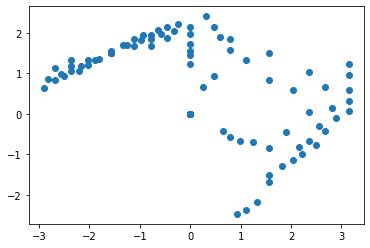

In [264]:
plt.scatter(phi_flat, theta_flat)

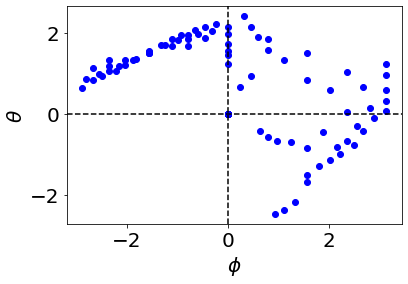

In [274]:

# Example data
x = phi_flat
y = theta_flat

# Sort the x array and store the corresponding order indices
sorted_indices = sorted(range(len(x)), key=lambda k: x[k])
sorted_x = [x[i] for i in sorted_indices]
sorted_y = [y[i] for i in sorted_indices]

# Create the plot
plt.scatter(sorted_x, sorted_y, marker='o', linestyle='-', color='b')
plt.xlabel(r'$\phi$', fontsize = 20)
plt.ylabel(r'$\theta$', fontsize = 20)

plt.axvline(x = 0, linestyle = '--', color = 'k')
plt.axhline(y = 0, linestyle = '--', color = 'k')
plt.tick_params(axis = 'both', labelsize = 20)
plt.show()
